# Pole Balancing Results

## Setup

In [21]:
import pickle

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from custom_neat.nn.recurrent import RNN
from custom_neat.genome import Genome

import cart_pole

In [2]:
BASE_DIR = '../experiments/single_pole_balancing_no_velocities/'

## Performance

In [3]:
def load_genome(path):
    """Load a pickled genome.
    
    Args:
        path (str): The path to the pickled genome object.
    
    Returns:
        Genome: The genome.
    """
    return pickle.load(open(path, 'rb'))

In [4]:
def evaluate_genome(genome, action_space, n_episodes=10, max_time_steps=1000):
    """Evaluate a genome.
    
    Genomes are evaluated by measuring the average balance time over a
    number of episodes.
    
    Args:
        genome (Genome): The genome to evaluate.
        action_space (str): The action space the agent was trained on. Either
            'continuous' or 'discrete'.
        n_episodes (int): The number of episodes over which to evaluate the
            agent.
        max_time_steps (int): The maximum number of time steps to evaluate a
            genome for.
    Returns:
        float: The average fitness over all episodes.
    """
    network = RNN.create(genome)
    
    episode_fitnesses = []
    for i in range(n_episodes):
        sim = cart_pole.CartPole(x=0.0, dx=0.0, theta=1.0, dtheta=0.0)
        network.reset()
        time_steps = 0

        while time_steps < max_time_steps:
            # Get normalised inputs in the range [-1, 1]
            observation = sim.get_scaled_state()
            observation = [observation[0], observation[2]]  # Remove velocities

            output = network.forward(observation)
            
            if action_space == 'continuous':
                action = cart_pole.continuous_actuator_force(output)
            elif action_space == 'discrete':
                action = cartpole.discrete_actuator_force(output)
            else:
                raise RuntimeError(f'Invalid action space: {action_space}')

            sim.step(action)
            sim.step(0)  # Skip every 2nd time step

            # Stop if network fails to keep the cart within the position or
            # angle limits
            if abs(sim.x) >= sim.position_limit or abs(sim.theta) >= sim.angle_limit_radians:
                break

            time_steps += 1

        episode_fitnesses.append(sim.t)

    return sum(episode_fitnesses) / len(episode_fitnesses)

### Continuous Action Space, Oscillation Dampening Fitness Function

First, perform a set of evolutionary runs using $1.0$ in the fitness function.

In [8]:
path_template = BASE_DIR + '/cont_oscil_results/run_{}/solution_{}.pickle'

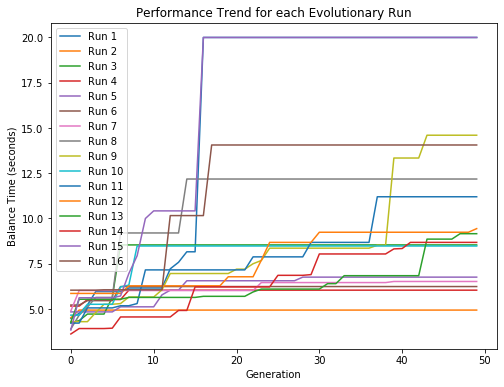

In [9]:
# Plot fitness over time for each run
plt.figure(figsize=(8,6))

generations = [i for i in range(50)]
for run in range(1, 17):
    genomes = [load_genome(path_template.format(run, g)) for g in generations]
    balance_times = [evaluate_genome(g, 'continuous') for g in genomes]
    
    plt.plot(generations, balance_times, label=f'Run {run}')
    
plt.title('Performance Trend for each Evolutionary Run')
plt.xlabel('Generation')
plt.ylabel('Balance Time (seconds)')
plt.legend(loc='best')
plt.show()

Second, perform a set of evolutionary runs using $0.75$ in the fitness function.

In [10]:
path_template = BASE_DIR + '/cont_oscil_results_2/run_{}/solution_{}.pickle'

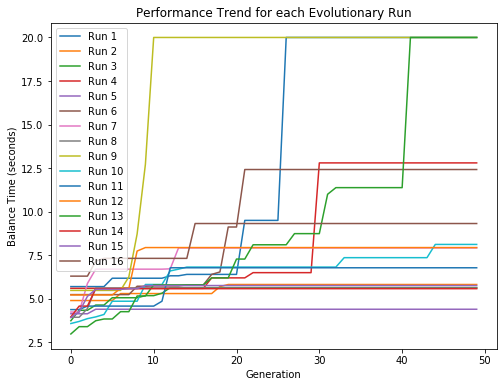

In [11]:
# Plot fitness over time for each run
plt.figure(figsize=(8,6))

generations = [i for i in range(50)]
for run in range(1, 17):
    genomes = [load_genome(path_template.format(run, g)) for g in generations]
    balance_times = [evaluate_genome(g, 'continuous') for g in genomes]
    
    plt.plot(generations, balance_times, label=f'Run {run}')
    
plt.title('Performance Trend for each Evolutionary Run')
plt.xlabel('Generation')
plt.ylabel('Balance Time (seconds)')
plt.legend(loc='best')
plt.show()

### Continuous Action Space, Balance Time Fitness Function

In [10]:
path_template = BASE_DIR + '/cont_basic_results/run_{}/solution_{}.pickle'

In [ ]:
# Plot fitness over time for each run
plt.figure(figsize=(8,6))

generations = [i for i in range(50)]
for run in range(1, 13):
    genomes = [load_genome(path_template.format(run, g)) for g in generations]
    balance_times = [evaluate_genome(g, 'continuous') for g in genomes]
    
    plt.plot(generations, balance_times, label=f'Run {run}')
    
plt.title('Performance Trend for each Evolutionary Run')
plt.xlabel('Generation')
plt.ylabel('Balance Time (seconds)')
plt.legend(loc='best')
plt.show()

### Discrete Action Space, Oscillation Dampening Fitness Function

In [10]:
path_template = BASE_DIR + '/disc_oscil_results/run_{}/solution_{}.pickle'

In [ ]:
# Plot fitness over time for each run
plt.figure(figsize=(8,6))

generations = [i for i in range(50)]
for run in range(1, 13):
    genomes = [load_genome(path_template.format(run, g)) for g in generations]
    balance_times = [evaluate_genome(g, 'continuous') for g in genomes]
    
    plt.plot(generations, balance_times, label=f'Run {run}')
    
plt.title('Performance Trend for each Evolutionary Run')
plt.xlabel('Generation')
plt.ylabel('Balance Time (seconds)')
plt.legend(loc='best')
plt.show()

### Discrete Action Space, Balance Time Fitness Function

In [10]:
path_template = BASE_DIR + '/cont_oscil_results/run_{}/solution_{}.pickle'

In [ ]:
# Plot fitness over time for each run
plt.figure(figsize=(8,6))

generations = [i for i in range(50)]
for run in range(1, 13):
    genomes = [load_genome(path_template.format(run, g)) for g in generations]
    balance_times = [evaluate_genome(g, 'continuous') for g in genomes]
    
    plt.plot(generations, balance_times, label=f'Run {run}')
    
plt.title('Performance Trend for each Evolutionary Run')
plt.xlabel('Generation')
plt.ylabel('Balance Time (seconds)')
plt.legend(loc='best')
plt.show()

## Structure

In [12]:
def genome_to_networkx(genome):
    """Create a NetworkX graph from a genome.
    
    Args:
        genome (Genome): The genome to construct the network from.
        
    Returns:
        DiGraph: The NetworkX graph of the neural network encoded
            by the genome.
    """
    graph = nx.DiGraph()
    graph.graph['edge'] = {'splines': 'curved'}  # graphviz
    
    # Add nodes to graph
    for key, gene in genome.nodes.items():
        graph.add_node(key,
                       type=gene.type,
                       bias=gene.bias,
                       activation=gene.activation,
                       label=f'{key}: {gene.bias:+.3f}')  # graphviz
        
    # Add edges to graph
    for key, gene in genome.connections.items():
        colour = 'green' if gene.expressed else 'red'
        graph.add_edge(gene.in_node,
                       gene.out_node,
                       weight=gene.weight,
                       expressed=gene.expressed,
                       color=colour,  # graphviz
                       label=f'{gene.weight:+.3f}')  # graphviz
        
    return graph

In [13]:
def pad(img, desired_size):
    """Pad a 3D numpy array to the desired size.
    
    This function is designed to pad 3D numpy arrays that
    represent RGB images with white pixels. Resulting images
    are of the desired size and have a 1:1 aspect ratio.
    
    Args:
        img (array): A 3D numpy array representing an image.
        desired_size (int): The desired height/width of the
            padded image/array.
    """
    pad_left = (desired_size - img.shape[0]) // 2
    pad_right = desired_size - img.shape[0] - pad_left
    pad_top = (desired_size - img.shape[1]) // 2
    pad_bottom = desired_size - img.shape[1] - pad_top
    
    img = np.pad(img,
                 pad_width=((pad_left, pad_right), (pad_top, pad_bottom), (0, 0)),
                 mode='constant', constant_values=(255))
    
    return img

### Continuous Action Space, Oscillation Dampening Fitness Function

In [17]:
path_template = BASE_DIR + '/cont_oscil_results_2/run_{}/solution.pickle'

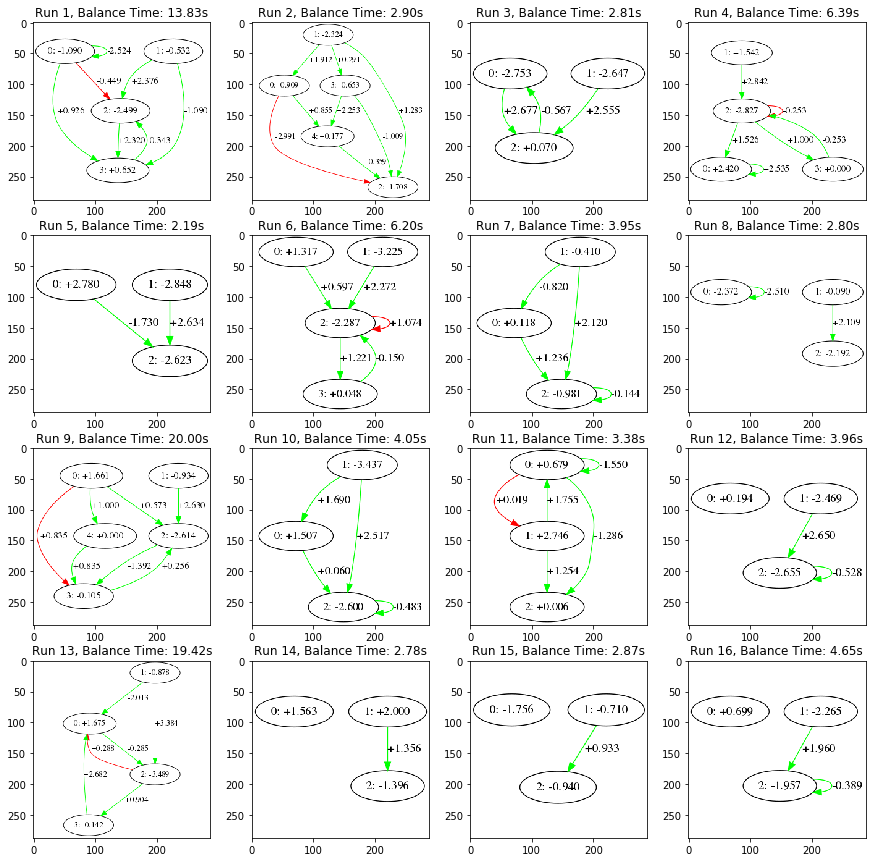

In [26]:
# Draw the best genomes each run
n_subplots = 16
cols = 4
rows = n_subplots // cols + n_subplots % cols

plt_position = range(1, n_subplots + 1)

fig = plt.figure(1, figsize=(15, 15))
for k in range(n_subplots):
    genome = load_genome(path_template.format(k + 1))
    graph = genome_to_networkx(genome)
    
    ax = fig.add_subplot(rows, cols, plt_position[k])
    
    graph = nx.drawing.nx_agraph.to_agraph(graph)
    graph.graph_attr['size'] = '3!, 3!'
    graph.graph_attr['ratio'] = 'compress'
    graph.layout('dot')
    graph.draw('graph.png')
    
    # Pad image
    img = Image.open('graph.png')
    img = np.array(img)
    img = pad(img, 288)
    
    # Pad image
    img = np.array(img)
    
    plt.title(f'Run {k + 1}, Balance Time: {genome.fitness * 0.01:.2f}s')
    plt.imshow(img)
    
plt.show()